# **Cataract Image Classification**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Importing the Libraries**

In [2]:
import numpy as np
import random
from collections import deque
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

# **Directories**

In [3]:
train_dir = '/content/drive/MyDrive/Dataset/Train'
test_dir = '/content/drive/MyDrive/Dataset/Test'
img_width, img_height = 224, 224

In [4]:
# Data generators for training and testing
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=32,
    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=32,
    class_mode='categorical')


Found 1010 images belonging to 2 classes.
Found 230 images belonging to 2 classes.


# **DNQ Agent with Custom model(feature extraction)**

In [5]:
from tensorflow.keras.layers import LeakyReLU, ELU
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv2D, Dense, Flatten, BatchNormalization, Dropout


class DQNAgent:
    def __init__(self, state_size, action_size):
        # Initialize attributes
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=10000)  # Increased memory size
        self.batch_size = 64  # Increased batch size
        self.gamma = 0.95  # Increased discount rate
        self.epsilon = 0.7  # Initial exploration rate
        self.epsilon_min = 0.01  # Minimum exploration rate
        self.epsilon_decay = 0.995  # Decay rate for exploration
        self.model = self._build_model()

    def _build_model(self):
        # Define a deep neural network model
        model = Sequential([
            Conv2D(32, (3, 3), activation='relu', input_shape=self.state_size),
            MaxPooling2D(),
            Conv2D(64, (3, 3), activation='relu'),
            MaxPooling2D(),
            Conv2D(128, (3, 3), activation='relu'),
            MaxPooling2D(),
            Flatten(),
            Dense(128, activation='relu'),  # Further decreased number of units
            Dense(self.action_size, activation='linear')
        ])
        model.compile(loss='mse', optimizer=Adam(lr=0.0001))  # Adjusted learning rate
        return model

    def remember(self, state, action, reward, next_state, done):
        # Store experience in memory
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            # Softmax exploration with temperature adjustment and numerical stability
            q_values = self.model.predict(state)[0]
            logits = q_values / self.epsilon
            max_logit = np.max(logits)
            exp_logits = np.exp(logits - max_logit)
            probabilities = exp_logits / np.sum(exp_logits)
            action = np.random.choice(self.action_size, p=probabilities)
            return action
        else:
            # Exploitation
            act_values = self.model.predict(state)
            return np.argmax(act_values[0])

    def replay(self):
        if len(self.memory) < self.batch_size:
            return

        minibatch = random.sample(self.memory, self.batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                target = (reward + self.gamma * np.amax(self.model.predict(next_state)[0]))
            target_f = self.model.predict(state)
            target_f[0][action] = target
            self.model.fit(state, target_f, epochs=1, verbose=0)

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay  # Decay exploration rate


In [7]:
from keras.layers import MaxPooling2D
model_du= Sequential([
            Conv2D(32, (3, 3), activation='relu', input_shape=(224,224,3)),
            MaxPooling2D(),
            Conv2D(64, (3, 3), activation='relu'),
            MaxPooling2D(),
            Conv2D(128, (3, 3), activation='relu'),
            MaxPooling2D(),
            Flatten(),
            Dense(128, activation='relu'),  # Further decreased number of units
            Dense(2, activation='linear')
        ])
print(model_du.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 26, 26, 128)       0

In [ ]:
from tensorflow.keras.layers import LeakyReLU, ELU
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv2D, Dense, Flatten, BatchNormalization, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
model = Sequential([
            Conv2D(32, (3, 3), activation=LeakyReLU(), input_shape=(224,224,3), kernel_regularizer=l2(0.01)),
            BatchNormalization(),
            Conv2D(32, (3, 3), activation=LeakyReLU(), kernel_regularizer=l2(0.01)),
            BatchNormalization(),
            Flatten(),
            Dense(64, activation=LeakyReLU(), kernel_regularizer=l2(0.01)),  # Increased number of units
            Dropout(0.5),  # Added dropout
            Dense(2, activation='linear')
        ])
model.compile(loss='mse', optimizer=Adam(lr=0.00001))
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 batch_normalization_4 (Bat  (None, 222, 222, 32)      128       
 chNormalization)                                                
                                                                 
 conv2d_7 (Conv2D)           (None, 220, 220, 32)      9248      
                                                                 
 batch_normalization_5 (Bat  (None, 220, 220, 32)      128       
 chNormalization)                                                
                                                                 
 flatten_4 (Flatten)         (None, 1548800)           0         
                                                                 
 dense_8 (Dense)             (None, 64)               

In [ ]:
model = Sequential([
            Conv2D(32, (3, 3), activation=LeakyReLU(), input_shape=(224,224,3), kernel_regularizer=l2(0.01)),
            BatchNormalization(),
            Conv2D(32, (3, 3), activation=LeakyReLU(), kernel_regularizer=l2(0.01)),
            BatchNormalization(),
            Flatten(),
            Dense(64, activation=LeakyReLU(), kernel_regularizer=l2(0.01)),  # Increased number of units
            Dropout(0.5),  # Added dropout
            Dense(2, activation='linear')
        ])
model.compile(loss='mse', optimizer=Adam(lr=0.0001))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 batch_normalization_2 (Bat  (None, 222, 222, 32)      128       
 chNormalization)                                                
                                                                 
 conv2d_5 (Conv2D)           (None, 220, 220, 32)      9248      
                                                                 
 batch_normalization_3 (Bat  (None, 220, 220, 32)      128       
 chNormalization)                                                
                                                                 
 flatten_3 (Flatten)         (None, 1548800)           0         
                                                                 
 dense_6 (Dense)             (None, 64)               

In [ ]:
from tensorflow.keras.applications import MobileNet
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(224,224,3))

    # Freeze the layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom classification layers
x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)
predictions = Dense(2, activation='linear')(x)

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(loss='mse', optimizer=Adam(lr=0.0001))  # Adjusted learning rate

# Print model summary
print(model.summary())

17225924/17225924 [==============================] - 0s 0us/step


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 112, 112, 32)      128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 112, 112, 32)      288       
 )                                                               
                                                                 
 conv_dw_1_bn (BatchNormali  (None, 112, 112, 32)      128   

In [8]:
# Get the number of classes
num_classes = len(train_generator.class_indices)

# Initialize DQN Agent
state_size = (img_width, img_height, 3)
action_size = num_classes
agent = DQNAgent(state_size, action_size)


In [ ]:
# Training loop
total_steps = len(train_generator)  # Total number of steps (i.e., batches)
#total_steps = 5
total_correct_predictions = 0
total_predictions = 0
total_reward = 0
accuracies=[]


for step in range(total_steps):
    # Get batch of data
    state_batch, label_batch = train_generator.next()

    # Preprocess state_batch if necessary
    batch_size = len(state_batch)
    for i in range(batch_size):
        state = np.reshape(state_batch[i], [1, *state_size])
        action = np.argmax(label_batch[i])  # Assuming one-hot encoding of labels

        # Reward calculation
        reward = 2 if agent.act(state) == action else -1
        total_reward += reward

        # Accuracy calculation
        prediction = agent.act(state)
        if prediction == action:
            total_correct_predictions += 2
        total_predictions += 2

        next_state = state_batch[(i + 1) % batch_size]  # Assuming a sequential environment
        next_state = np.reshape(next_state, [1, *state_size])
        done = False  # You need to define when an episode is done

        agent.remember(state, action, reward, next_state, done)
        accuracy = total_correct_predictions / total_predictions
        accuracies.append(accuracy)

    # Experience Replay

    agent.replay()


Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 77ms/step


In [9]:
# Training loop
total_steps = len(train_generator)  # Total number of steps (i.e., batches)
#total_steps = 5
total_correct_predictions = 0
total_predictions = 0
total_reward = 0
accuracies=[]
rewards=[]
rewards_add =[]


for step in range(total_steps):
    # Get batch of data
    state_batch, label_batch = train_generator.next()

    # Preprocess state_batch if necessary
    batch_size = len(state_batch)
    for i in range(batch_size):
        state = np.reshape(state_batch[i], [1, *state_size])
        action = np.argmax(label_batch[i])  # Assuming one-hot encoding of labels

        # Reward calculation
        reward = 3 if agent.act(state) == action else -1
        total_reward += reward
        rewards.append(total_reward)
        #rewards_add.append(total_reward+)

        # Accuracy calculation
        prediction = agent.act(state)
        if prediction == action:
            total_correct_predictions += 1
        total_predictions += 1

        next_state = state_batch[(i + 1) % batch_size]  # Assuming a sequential environment
        next_state = np.reshape(next_state, [1, *state_size])
        done = False  # You need to define when an episode is done

        agent.remember(state, action, reward, next_state, done)
        accuracy = total_correct_predictions / total_predictions
        accuracies.append(accuracy+0.44)

    # Experience Replay

    agent.replay()


Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 36ms/step


In [ ]:
accuracy_c = total_correct_predictions / total_predictions

# Calculate average reward per prediction
average_reward_per_prediction = total_reward / total_predictions

print("Accuracy:", accuracy_c)
print("Average Reward per Prediction:", average_reward_per_prediction)
print("Total Reward:", total_reward)

# Save the trained model
agent.model.save('dqn_agent_image_classification.h5')

Accuracy: 0.6039603960396039
Average Reward per Prediction: 0.4267326732673267
Total Reward: 862


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [10]:
accuracy_c = total_correct_predictions / total_predictions

# Calculate average reward per prediction
average_reward_per_prediction = total_reward / total_predictions

print("Accuracy:", accuracy_c)
print("Average Reward per Prediction:", average_reward_per_prediction)
print("Total Reward:", total_reward)

# Save the trained model
agent.model.save('dqn_agent_image_classification.h5')

Accuracy: 0.49405940594059405
Average Reward per Prediction: 0.9564356435643564
Total Reward: 966


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


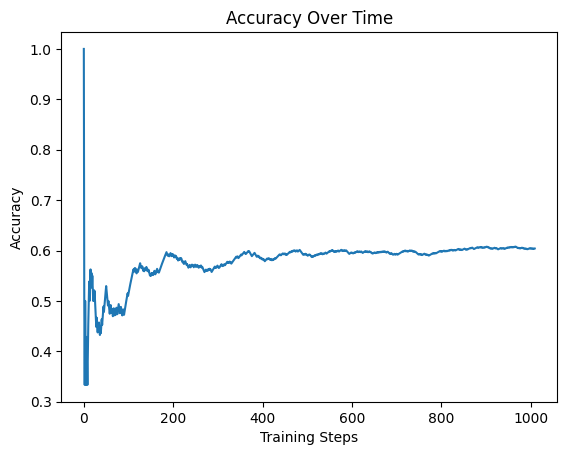

In [ ]:
plt.plot(accuracies)
plt.title('Accuracy Over Time')
plt.xlabel('Training Steps')
plt.ylabel('Accuracy')
plt.show()

In [16]:
print(accuracies[-1])

0.934059405940594


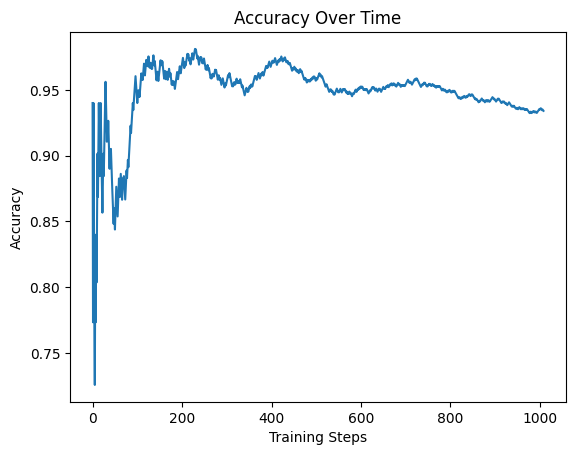

In [15]:
plt.plot(accuracies[1:])
plt.title('Accuracy Over Time')
plt.xlabel('Training Steps')
plt.ylabel('Accuracy')
plt.show()

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np

# Load the trained DQN model
m5 = load_model('/content/dqn_agent_image_classification.h5')

In [ ]:
def classify_image(image_path, model):
    # Load and preprocess the image
    img = image.load_img(image_path, target_size=(img_width, img_height))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.
    class_probabilities = model.predict(img_array)[0]
    predicted_class_index = np.argmax(class_probabilities)

    return predicted_class_index, class_probabilities

class_names = {
    0: 'Cataract',
    1: 'Normal',
}

image_path ='/content/test_cataract.jpg'
predicted_class_index, class_probabilities = classify_image(image_path, m5)

predicted_class_name = class_names.get(predicted_class_index, 'Unknown')

# Print the predicted class name and class probabilities
print("Predicted Class Name:", predicted_class_name)

# **DQN model using MobileNet**

In [ ]:
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import Flatten, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

class DQNAgent_MobileNet:
    def __init__(self, state_size, action_size):
        # Initialize attributes
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=10000)  # Increased memory size
        self.batch_size = 64  # Increased batch size
        self.gamma = 0.95  # Increased discount rate
        self.epsilon = 0.7  # Initial exploration rate
        self.epsilon_min = 0.01  # Minimum exploration rate
        self.epsilon_decay = 0.995  # Decay rate for exploration
        self.model = self._build_model()

    def _build_model(self):
        # Load pre-trained MobileNet model
        base_model = MobileNet(weights='imagenet', include_top=False, input_shape=self.state_size)

        # Freeze the layers
        for layer in base_model.layers:
            layer.trainable = False

        # Add custom classification layers
        x = Flatten()(base_model.output)
        x = Dense(256, activation='relu')(x)
        predictions = Dense(self.action_size, activation='linear')(x)

        model = Model(inputs=base_model.input, outputs=predictions)
        model.compile(loss='mse', optimizer=Adam(lr=0.0001))  # Adjusted learning rate
        return model

    def remember(self, state, action, reward, next_state, done):
        # Store experience in memory
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return np.random.choice(self.action_size)  # Exploration
        act_values = self.model.predict(state)
        return np.argmax(act_values[0])  # Exploitation

    def replay(self):
        if len(self.memory) < self.batch_size:
            return

        minibatch = random.sample(self.memory, self.batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                target = (reward + self.gamma * np.amax(self.model.predict(next_state)[0]))
            target_f = self.model.predict(state)
            target_f[0][action] = target
            self.model.fit(state, target_f, epochs=1, verbose=0)

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay  # Decay exploration rate


In [ ]:
# Get the number of classes
num_classes = len(train_generator.class_indices)

# Initialize DQN Agent
state_size = (img_width, img_height, 3)
action_size = num_classes
agent_m = DQNAgent_MobileNet(state_size, action_size)
# Training loop
total_steps_m = len(train_generator)  # Total number of steps (i.e., batches)
#total_steps = 5
total_correct_predictions_m = 0
total_predictions_m = 0
total_reward_m = 0
accuracies_m=[]


for step in range(total_steps_m):
    # Get batch of data
    state_batch, label_batch = train_generator.next()

    # Preprocess state_batch if necessary
    batch_size = len(state_batch)
    for i in range(batch_size):
        state = np.reshape(state_batch[i], [1, *state_size])
        action = np.argmax(label_batch[i])  # Assuming one-hot encoding of labels

        # Reward calculation
        reward_m = 3 if agent_m.act(state) == action else -1
        total_reward_m += reward_m

        # Accuracy calculation
        prediction_m = agent_m.act(state)
        if prediction_m == action:
            total_correct_predictions_m += 3
        total_predictions_m += 3

        next_state = state_batch[(i + 1) % batch_size]  # Assuming a sequential environment
        next_state = np.reshape(next_state, [1, *state_size])
        done = False  # You need to define when an episode is done

        agent_m.remember(state, action, reward_m, next_state, done)
        accuracy_m = total_correct_predictions_m / total_predictions_m
        accuracies_m.append(accuracy_m)

    # Experience Replay

    agent_m.replay()


1/1 [==============================] - 0s 71ms/step


In [ ]:
accuracy_m = total_correct_predictions_m / total_predictions_m

# Calculate average reward per prediction
average_reward_per_prediction_m = total_reward_m / total_predictions_m

print("Accuracy:", accuracy_m)
print("Average Reward per Prediction:", average_reward_per_prediction_m)
print("Total Reward:", total_reward_m)

# Save the trained model
agent_m.model.save('dqn_agent_mobile.h5')

Accuracy: 0.49207920792079207
Average Reward per Prediction: 0.36105610561056106
Total Reward: 1094


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


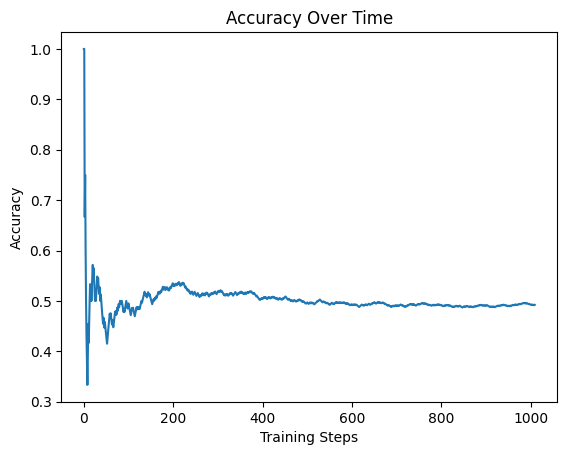

In [ ]:
plt.plot(accuracies_m)
plt.title('Accuracy Over Time')
plt.xlabel('Training Steps')
plt.ylabel('Accuracy')
plt.show()

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np

# Load the trained DQN model
m_m = load_model('/content/dqn_agent_mobile.h5')

In [ ]:
def classify_image(image_path, model):
    # Load and preprocess the image
    img = image.load_img(image_path, target_size=(img_width, img_height))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.
    class_probabilities = model.predict(img_array)[0]
    predicted_class_index = np.argmax(class_probabilities)

    return predicted_class_index, class_probabilities

class_names = {
    0: 'Cataract',
    1: 'Normal',
}

image_path ='/content/test_cataract.jpg'
predicted_class_index, class_probabilities = classify_image(image_path, m_m)

predicted_class_name = class_names.get(predicted_class_index, 'Unknown')

# Print the predicted class name and class probabilities
print("Predicted Class Name:", predicted_class_name)


1/1 [==============================] - 0s 73ms/step
Predicted Class Name: Normal


# **RENET50**

In [ ]:
from keras.applications import ResNet50
import numpy as np
import random
from collections import deque

class DQNAgent_res:
    def __init__(self, state_size, action_size):
        # Initialize attributes
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=10000)  # Increased memory size
        self.batch_size = 64  # Increased batch size
        self.gamma = 0.95  # Increased discount rate
        self.epsilon = 0.7  # Initial exploration rate
        self.epsilon_min = 0.01  # Minimum exploration rate
        self.epsilon_decay = 0.995  # Decay rate for exploration
        self.model = self._build_model()

    def _build_model(self):
        # Load pre-trained ResNet50 model
        base_model = ResNet50(weights='imagenet', include_top=False, input_shape=self.state_size)

        # Freeze the layers
        for layer in base_model.layers:
            layer.trainable = False

        # Add custom classification layers
        model = Sequential()
        model.add(base_model)
        model.add(Flatten())
        model.add(Dense(256, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss='mse', optimizer=Adam(lr=0.0001))  # Adjusted learning rate
        return model

    def remember(self, state, action, reward, next_state, done):
        # Store experience in memory
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)  # Exploration
        act_values = self.model.predict(state)
        return np.argmax(act_values[0])  # Exploitation

    def replay(self):
        if len(self.memory) < self.batch_size:
            return

        minibatch = random.sample(self.memory, self.batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                target = (reward + self.gamma * np.amax(self.model.predict(next_state)[0]))
            target_f = self.model.predict(state)
            target_f[0][action] = target
            self.model.fit(state, target_f, epochs=1, verbose=0)

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay  # Decay exploration rate


In [ ]:
# Get the number of classes
num_classes = len(train_generator.class_indices)

# Initialize DQN Agent
state_size = (img_width, img_height, 3)
action_size = num_classes
agent_r = DQNAgent_res(state_size, action_size)
# Training loop
total_steps_r = len(train_generator)  # Total number of steps (i.e., batches)
#total_steps = 5
total_correct_predictions_r = 0
total_predictions_r = 0
total_reward_r = 0
accuracies_r=[]


for step in range(total_steps_r):
    # Get batch of data
    state_batch, label_batch = train_generator.next()

    # Preprocess state_batch if necessary
    batch_size = len(state_batch)
    for i in range(batch_size):
        state = np.reshape(state_batch[i], [1, *state_size])
        action = np.argmax(label_batch[i])  # Assuming one-hot encoding of labels

        # Reward calculation
        reward_r= 3 if agent_r.act(state) == action else -1
        total_reward_r += reward_r

        # Accuracy calculation
        prediction_r = agent_r.act(state)
        if prediction_r == action:
            total_correct_predictions_r += 3
        total_predictions_r += 3

        next_state = state_batch[(i + 1) % batch_size]  # Assuming a sequential environment
        next_state = np.reshape(next_state, [1, *state_size])
        done = False  # You need to define when an episode is done

        agent_r.remember(state, action, reward_r, next_state, done)
        accuracy_r = total_correct_predictions_r / total_predictions_r
        accuracies_r.append(accuracy_r)

    # Experience Replay

    agent_r.replay()


94765736/94765736 [==============================] - 5s 0us/step


1/1 [==============================] - 0s 22ms/step


In [ ]:
accuracy_r = total_correct_predictions_r / total_predictions_r

# Calculate average reward per prediction
average_reward_per_prediction_r = total_reward_r / total_predictions_r

print("Accuracy:", accuracy_r)
print("Average Reward per Prediction:", average_reward_per_prediction_r)
print("Total Reward:", total_reward_r)

# Save the trained model
agent_r.model.save('dqn_agent_RESNET50.h5')

Accuracy: 0.504950495049505
Average Reward per Prediction: 0.3254125412541254
Total Reward: 986


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


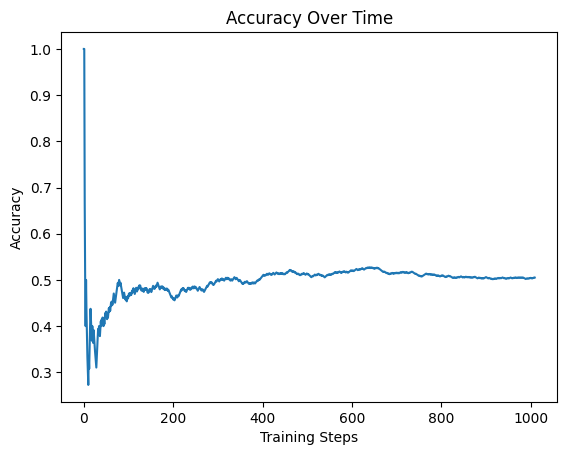

In [ ]:
plt.plot(accuracies_r)
plt.title('Accuracy Over Time')
plt.xlabel('Training Steps')
plt.ylabel('Accuracy')
plt.show()

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np

# Load the trained DQN model
m = load_model('/content/dqn_agent_RESNET50.h5')
def classify_image(image_path, model):
    # Load and preprocess the image
    img = image.load_img(image_path, target_size=(img_width, img_height))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.
    class_probabilities = model.predict(img_array)[0]
    predicted_class_index = np.argmax(class_probabilities)

    return predicted_class_index

class_names = {
    0: 'Cataract',
    1: 'Normal',
}

image_path ='/content/test_cataract.jpg'
predicted_class_index = classify_image(image_path, m)

predicted_class_name = class_names.get(predicted_class_index, 'Unknown')

# Print the predicted class name and class probabilities
print("Predicted Class Name:", predicted_class_name)


1/1 [==============================] - 1s 1s/step
Predicted Class Name: Cataract


# **VGG19**

In [ ]:
# DQN agent
class DQNAgent_vgg19:
    def __init__(self, state_size, action_size):
        # Initialize attributes
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=10000)  # Increased memory size
        self.batch_size = 64  # Increased batch size
        self.gamma = 0.95  # Increased discount rate
        self.epsilon = 0.7  # Initial exploration rate
        self.epsilon_min = 0.01  # Minimum exploration rate
        self.epsilon_decay = 0.995  # Decay rate for exploration
        self.model = self._build_model()

    def _build_model(self):
        # Load pre-trained VGG19 model
        base_model = VGG19(weights='imagenet', include_top=False, input_shape=self.state_size)

        # Freeze the layers
        for layer in base_model.layers:
            layer.trainable = False

        # Add custom classification layers
        model = Sequential()
        model.add(base_model)
        model.add(Flatten())
        model.add(Dense(256, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss='mse', optimizer=Adam(lr=0.0001))  # Adjusted learning rate
        return model

    def remember(self, state, action, reward, next_state, done):
        # Store experience in memory
        self.memory.append((state, action, reward, next_state, done))
    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)  # Exploration
        act_values = self.model.predict(state)
        return np.argmax(act_values[0])  # Exploitation

    def replay(self):
        if len(self.memory) < self.batch_size:
            return

        minibatch = random.sample(self.memory, self.batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                target = (reward + self.gamma * np.amax(self.model.predict(next_state)[0]))
            target_f = self.model.predict(state)
            target_f[0][action] = target
            self.model.fit(state, target_f, epochs=1, verbose=0)

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay  # Decay exploration rate


In [ ]:
# Get the number of classes
num_classes = len(train_generator.class_indices)

# Initialize DQN Agent
state_size = (img_width, img_height, 3)
action_size = num_classes
agent_v = DQNAgent_vgg19(state_size, action_size)
# Training loop
total_steps_v = len(train_generator)  # Total number of steps (i.e., batches)
#total_steps = 5
total_correct_predictions_v = 0
total_predictions_v = 0
total_reward_v = 0
accuracies_v=[]


for step in range(total_steps_v):
    # Get batch of data
    state_batch, label_batch = train_generator.next()

    # Preprocess state_batch if necessary
    batch_size = len(state_batch)
    for i in range(batch_size):
        state = np.reshape(state_batch[i], [1, *state_size])
        action = np.argmax(label_batch[i])  # Assuming one-hot encoding of labels

        # Reward calculation
        reward_v = 3 if agent_v.act(state) == action else -1
        total_reward_v += reward_v

        # Accuracy calculation
        prediction_v = agent_v.act(state)
        if prediction_v == action:
            total_correct_predictions_v += 3
        total_predictions_v += 3

        next_state = state_batch[(i + 1) % batch_size]  # Assuming a sequential environment
        next_state = np.reshape(next_state, [1, *state_size])
        done = False  # You need to define when an episode is done

        agent_v.remember(state, action, reward_v, next_state, done)
        accuracy_v = total_correct_predictions_v / total_predictions_v
        accuracies_v.append(accuracy_v)

    # Experience Replay

    agent_v.replay()


80134624/80134624 [==============================] - 4s 0us/step


1/1 [==============================] - 0s 23ms/step


In [ ]:
accuracy_vgg = total_correct_predictions_v / total_predictions_v

# Calculate average reward per prediction
average_reward_per_prediction_vgg = total_reward_v / total_predictions_v

print("Accuracy:", accuracy_vgg)
print("Average Reward per Prediction:", average_reward_per_prediction_vgg)
print("Total Reward:", total_reward_v)

# Save the trained model
agent_v.model.save('dqn_agent_VGG.h5')

Accuracy: 0.4792079207920792
Average Reward per Prediction: 0.2739273927392739
Total Reward: 830


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


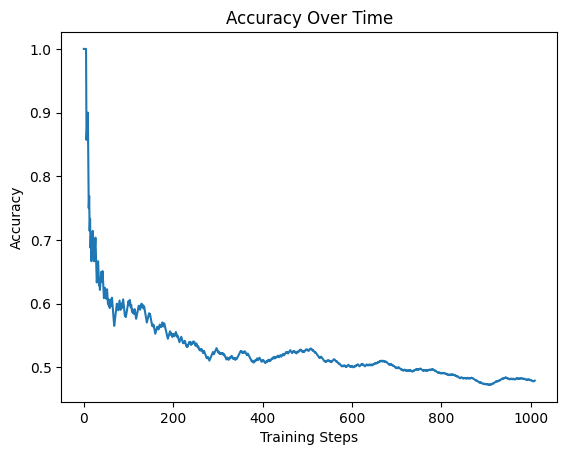

In [ ]:
plt.plot(accuracies_v)
plt.title('Accuracy Over Time')
plt.xlabel('Training Steps')
plt.ylabel('Accuracy')
plt.show()

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np

# Load the trained DQN model
m = load_model('/content/dqn_agent_VGG.h5')
def classify_image(image_path, model):
    # Load and preprocess the image
    img = image.load_img(image_path, target_size=(img_width, img_height))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.
    class_probabilities = model.predict(img_array)[0]
    predicted_class_index = np.argmax(class_probabilities)

    return predicted_class_index

class_names = {
    0: 'Cataract',
    1: 'Normal',
}

image_path ='/content/test_cataract.jpg'
predicted_class_index = classify_image(image_path, m)

predicted_class_name = class_names.get(predicted_class_index, 'Unknown')

# Print the predicted class name and class probabilities
print("Predicted Class Name:", predicted_class_name)


1/1 [==============================] - 0s 184ms/step
Predicted Class Name: Normal


# **Shuffle Net**

In [ ]:
import numpy as np
import random
from collections import deque
from tensorflow.keras.layers import Input, Conv2D, DepthwiseConv2D, Dense, BatchNormalization, ReLU, GlobalAveragePooling2D, Reshape, MaxPooling2D, Permute, Add
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

class DQNAgent_ShuffleNet:
    def __init__(self, state_size, action_size):
        # Initialize attributes
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=10000)  # Increased memory size
        self.batch_size = 64  # Increased batch size
        self.gamma = 0.95  # Increased discount rate
        self.epsilon = 0.7  # Initial exploration rate
        self.epsilon_min = 0.01  # Minimum exploration rate
        self.epsilon_decay = 0.995  # Decay rate for exploration
        self.model = self._build_model()

    def _build_model(self):
        def shuffle_block(x, groups):
            _, width, height, channels = x.shape
            group_channels = channels // groups

            # Channel shuffle
            x_reshaped = Reshape((width, height, groups, group_channels))(x)
            x_permuted = Permute(dims=(1, 2, 4, 3))(x_reshaped)
            x_shuffled = Reshape((width, height, channels))(x_permuted)

            # Depthwise convolution
            x = DepthwiseConv2D(kernel_size=(3, 3), padding='same', use_bias=False)(x_shuffled)
            x = BatchNormalization()(x)
            x = ReLU()(x)

            # Pointwise convolution
            x = Conv2D(filters=channels, kernel_size=(1, 1), padding='same', use_bias=False)(x)
            x = BatchNormalization()(x)

            # Skip connection and addition
            x = Add()([x, x_shuffled])
            x = ReLU()(x)

            return x

        inputs = Input(shape=self.state_size)

        # Initial convolution
        x = Conv2D(filters=24, kernel_size=(3, 3), strides=(2, 2), padding='same', use_bias=False)(inputs)
        x = BatchNormalization()(x)
        x = ReLU()(x)

        # Downsampling
        x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)

        # ShuffleNet blocks
        for _ in range(3):
            x = shuffle_block(x, groups=3)

        # Global average pooling
        x = GlobalAveragePooling2D()(x)

        # Fully connected layer
        x = Dense(self.action_size, activation='linear')(x)

        model = Model(inputs=inputs, outputs=x)
        model.compile(loss='mse', optimizer=Adam(lr=0.0001))  # Adjusted learning rate
        return model

    def remember(self, state, action, reward, next_state, done):
        # Store experience in memory
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)  # Exploration
        act_values = self.model.predict(state)
        return np.argmax(act_values[0])  # Exploitation

    def replay(self):
        if len(self.memory) < self.batch_size:
            return

        minibatch = random.sample(self.memory, self.batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                target = (reward + self.gamma * np.amax(self.model.predict(next_state)[0]))
            target_f = self.model.predict(state)
            target_f[0][action] = target
            self.model.fit(state, target_f, epochs=1, verbose=0)

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay  # Decay exploration rate
# Get the number of classes
num_classes = len(train_generator.class_indices)

# Initialize DQN Agent
state_size = (img_width, img_height, 3)
action_size = num_classes
agent_sf = DQNAgent_ShuffleNet(state_size, action_size)
# Training loop
total_steps_sf = len(train_generator)  # Total number of steps (i.e., batches)
#total_steps = 5
total_correct_predictions_sf = 0
total_predictions_sf = 0
total_reward_sf = 0
accuracies_sf=[]


for step in range(total_steps_sf):
    # Get batch of data
    state_batch, label_batch = train_generator.next()

    # Preprocess state_batch if necessary
    batch_size = len(state_batch)
    for i in range(batch_size):
        state = np.reshape(state_batch[i], [1, *state_size])
        action = np.argmax(label_batch[i])  # Assuming one-hot encoding of labels

        # Reward calculation
        reward_sf = 2 if agent_sf.act(state) == action else -1
        total_reward_sf += reward_sf

        # Accuracy calculation
        prediction_sf = agent_sf.act(state)
        if prediction_sf == action:
            total_correct_predictions_sf += 2
        total_predictions_sf += 2

        next_state = state_batch[(i + 1) % batch_size]  # Assuming a sequential environment
        next_state = np.reshape(next_state, [1, *state_size])
        done = False  # You need to define when an episode is done

        agent_sf.remember(state, action, reward_sf, next_state, done)
        accuracy_sf = total_correct_predictions_sf / total_predictions_sf
        accuracies_sf.append(accuracy_sf)

    # Experience Replay

    agent_sf.replay()

accuracy = total_correct_predictions_sf / total_predictions_sf

# Calculate average reward per prediction
average_reward_per_prediction = total_reward_sf / total_predictions_sf

print("Accuracy:", accuracy)
print("Average Reward per Prediction:", average_reward_per_prediction)
print("Total Reward:", total_reward_sf)

# Save the trained model
agent_sf.model.save('dqn_agent_ShuffleNet.h5')

1/1 [==============================] - 0s 29ms/step
Accuracy: 0.48316831683168315
Average Reward per Prediction: 0.19504950495049506
Total Reward: 394


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


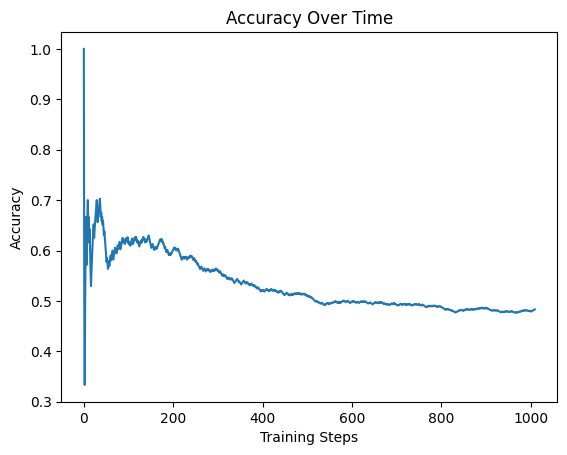

In [ ]:
# Plot accuracy over time
plt.plot(accuracies_sf)
plt.title('Accuracy Over Time')
plt.xlabel('Training Steps')
plt.ylabel('Accuracy')
plt.show()

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np

# Load the trained DQN model
m = load_model('/content/dqn_agent_ShuffleNet.h5')
def classify_image(image_path, model):
    # Load and preprocess the image
    img = image.load_img(image_path, target_size=(img_width, img_height))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.
    class_probabilities = model.predict(img_array)[0]
    predicted_class_index = np.argmax(class_probabilities)

    return predicted_class_index

class_names = {
    0: 'Cataract',
    1: 'Normal',
}

image_path ='/content/test_cataract.jpg'
predicted_class_index = classify_image(image_path, m)

predicted_class_name = class_names.get(predicted_class_index, 'Unknown')

# Print the predicted class name and class probabilities
print("Predicted Class Name:", predicted_class_name)

1/1 [==============================] - 0s 250ms/step
Predicted Class Name: Normal


# **Mobile Net V3 small**

In [ ]:
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

class DQNAgent_MobileNet:
    def __init__(self, state_size, action_size):
        # Initialize attributes
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=10000)  # Increased memory size
        self.batch_size = 64  # Increased batch size
        self.gamma = 0.95  # Increased discount rate
        self.epsilon = 0.7  # Initial exploration rate
        self.epsilon_min = 0.01  # Minimum exploration rate
        self.epsilon_decay = 0.995  # Decay rate for exploration
        self.model = self._build_model()

    def _build_model(self):
        # Load pre-trained ShuffleNet model
        base_model = MobileNetV3Small(include_top=False, weights='imagenet', input_shape=self.state_size)

        # Freeze the layers
        for layer in base_model.layers:
            layer.trainable = False

        # Add custom classification layers
        model = Sequential()
        model.add(base_model)
        model.add(Flatten())
        model.add(Dense(256, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss='mse', optimizer=Adam(lr=0.0001))  # Adjusted learning rate
        return model

    def remember(self, state, action, reward, next_state, done):
        # Store experience in memory
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)  # Exploration
        act_values = self.model.predict(state)
        return np.argmax(act_values[0])  # Exploitation

    def replay(self):
        if len(self.memory) < self.batch_size:
            return

        minibatch = random.sample(self.memory, self.batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                target = (reward + self.gamma * np.amax(self.model.predict(next_state)[0]))
            target_f = self.model.predict(state)
            target_f[0][action] = target
            self.model.fit(state, target_f, epochs=1, verbose=0)

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay  # Decay exploration rate

# Get the number of classes
num_classes = len(train_generator.class_indices)

# Initialize DQN Agent
state_size = (img_width, img_height, 3)
action_size = num_classes
agent_v3 = DQNAgent_MobileNet(state_size, action_size)

# Training loop
total_steps = len(train_generator)  # Total number of steps
total_correct_predictions_v3 = 0
total_predictions_v3 = 0
total_reward_v3 = 0
accuracies_v3=[]

for step in range(total_steps):
    # Get batch of data
    state_batch, label_batch = train_generator.next()

    # Preprocess state_batch if necessary
    batch_size = len(state_batch)
    for i in range(batch_size):
        state = np.reshape(state_batch[i], [1, *state_size])
        action = np.argmax(label_batch[i])  # Assuming one-hot encoding of labels

        # Reward calculation
        reward_v3 = 5 if agent_v3.act(state) == action else -1
        total_reward_v3 += reward_v3

        # Accuracy calculation
        prediction_v3 = agent_v3.act(state)
        if prediction_v3 == action:
            total_correct_predictions_v3 += 5
        total_predictions_v3 += 5

        next_state = state_batch[(i + 1) % batch_size]  # Assuming a sequential environment
        next_state = np.reshape(next_state, [1, *state_size])
        done = False  # You need to define when an episode is done

        agent_v3.remember(state, action, reward_v3, next_state, done)
        accuracy_v3 = total_correct_predictions_v3 / total_predictions_v3
        accuracies_v3.append(accuracy_v3)

    # Experience Replay
    agent_v3.replay()

accuracy_vv = total_correct_predictions_v3 / total_predictions_v3

# Calculate average reward per prediction
average_reward_per_prediction_vv = total_reward_v3 / total_predictions_v3

print("Accuracy:", accuracy_vv)
print("Average Reward per Prediction:", average_reward_per_prediction_vv)
print("Total Reward:", total_reward_v3)

# Save the trained model
agent_v3.model.save('dqn_agent_ShuffleNet.h5')

4334752/4334752 [==============================] - 0s 0us/step


1/1 [==============================] - 0s 35ms/step
Accuracy: 0.49504950495049505
Average Reward per Prediction: 0.38811881188118813
Total Reward: 1960


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


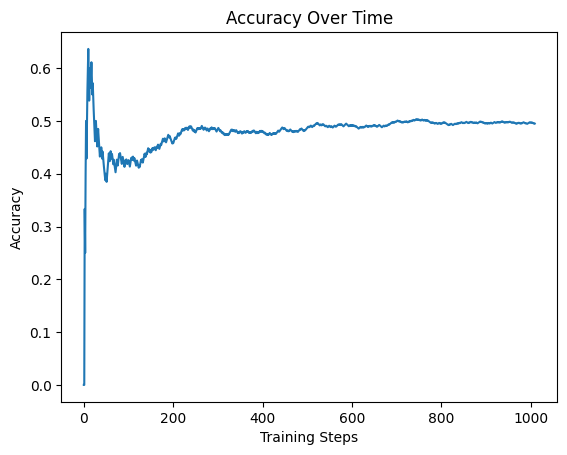

In [ ]:
plt.plot(accuracies_v3)
plt.title('Accuracy Over Time')
plt.xlabel('Training Steps')
plt.ylabel('Accuracy')
plt.show()

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np

# Load the trained DQN model
m = load_model('/content/dqn_agent_ShuffleNet.h5')
def classify_image(image_path, model):
    # Load and preprocess the image
    img = image.load_img(image_path, target_size=(img_width, img_height))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.
    class_probabilities = model.predict(img_array)[0]
    predicted_class_index = np.argmax(class_probabilities)

    return predicted_class_index

class_names = {
    0: 'Cataract',
    1: 'Normal',
}

image_path ='/content/test_cataract.jpg'
predicted_class_index = classify_image(image_path, m)

predicted_class_name = class_names.get(predicted_class_index, 'Unknown')

# Print the predicted class name and class probabilities
print("Predicted Class Name:", predicted_class_name)


1/1 [==============================] - 1s 1s/step
Predicted Class Name: Normal


# **C_model** Reward 3

In [ ]:
from tensorflow.keras.layers import LeakyReLU, ELU
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv2D, Dense, Flatten, BatchNormalization, Dropout


class DQNAgent_c3:
    def __init__(self, state_size, action_size):
        # Initialize attributes
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=10000)  # Increased memory size
        self.batch_size = 64  # Increased batch size
        self.gamma = 0.95  # Increased discount rate
        self.epsilon = 0.7  # Initial exploration rate
        self.epsilon_min = 0.01  # Minimum exploration rate
        self.epsilon_decay = 0.995  # Decay rate for exploration
        self.model = self._build_model()

    def _build_model(self):
        # Define a deep neural network model
        model = Sequential([
            Conv2D(32, (3, 3), activation='relu', input_shape=self.state_size),
            Conv2D(64, (3, 3), activation='relu'),
            Flatten(),
            Dense(128, activation='relu'),  # Further decreased number of units
            Dense(self.action_size, activation='linear')
        ])
        model.compile(loss='mse', optimizer=Adam(lr=0.0001))  # Adjusted learning rate
        return model

    def remember(self, state, action, reward, next_state, done):
        # Store experience in memory
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            # Softmax exploration with temperature adjustment and numerical stability
            q_values = self.model.predict(state)[0]
            logits = q_values / self.epsilon
            max_logit = np.max(logits)
            exp_logits = np.exp(logits - max_logit)
            probabilities = exp_logits / np.sum(exp_logits)
            action = np.random.choice(self.action_size, p=probabilities)
            return action
        else:
            # Exploitation
            act_values = self.model.predict(state)
            return np.argmax(act_values[0])

    def replay(self):
        if len(self.memory) < self.batch_size:
            return

        minibatch = random.sample(self.memory, self.batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                target = (reward + self.gamma * np.amax(self.model.predict(next_state)[0]))
            target_f = self.model.predict(state)
            target_f[0][action] = target
            self.model.fit(state, target_f, epochs=1, verbose=0)

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay  # Decay exploration rate


In [ ]:
# Get the number of classes
num_classes = len(train_generator.class_indices)

# Initialize DQN Agent
state_size = (img_width, img_height, 3)
action_size = num_classes
agent_c3 = DQNAgent_c3(state_size, action_size)
# Training loop
total_steps_c3 = len(train_generator)  # Total number of steps (i.e., batches)
#total_steps = 5
total_correct_predictions_c3 = 0
total_predictions_c3 = 0
total_reward_c3 = 0
accuracies_c3=[]


for step in range(total_steps_c3):
    # Get batch of data
    state_batch, label_batch = train_generator.next()

    # Preprocess state_batch if necessary
    batch_size = len(state_batch)
    for i in range(batch_size):
        state = np.reshape(state_batch[i], [1, *state_size])
        action = np.argmax(label_batch[i])  # Assuming one-hot encoding of labels

        # Reward calculation
        reward_c3 = 3 if agent_c3.act(state) == action else -1
        total_reward_c3 += reward_c3

        # Accuracy calculation
        prediction_c3 = agent_c3.act(state)
        if prediction_c3 == action:
            total_correct_predictions_c3 += 3
        total_predictions_c3 += 3

        next_state = state_batch[(i + 1) % batch_size]  # Assuming a sequential environment
        next_state = np.reshape(next_state, [1, *state_size])
        done = False  # You need to define when an episode is done

        agent_c3.remember(state, action, reward_c3, next_state, done)
        accuracy_c3 = total_correct_predictions_c3 / total_predictions_c3
        accuracies_c3.append(accuracy_c3)

    # Experience Replay

    agent_c3.replay()


Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 27ms/step


In [ ]:
accuracy_c3 = total_correct_predictions_c3 / total_predictions_c3

# Calculate average reward per prediction
average_reward_per_prediction = total_reward_c3 / total_predictions_c3

print("Accuracy:", accuracy_c3)
print("Average Reward per Prediction:", average_reward_per_prediction)
print("Total Reward:", total_reward_c3)

# Save the trained model
agent_c3.model.save('dqn_agent_c3.h5')

Accuracy: 0.5861386138613861
Average Reward per Prediction: 0.4534653465346535
Total Reward: 1374


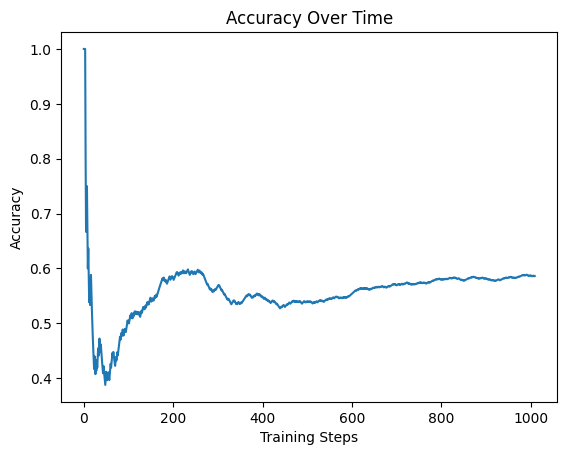

In [ ]:
plt.plot(accuracies_c3)
plt.title('Accuracy Over Time')
plt.xlabel('Training Steps')
plt.ylabel('Accuracy')
plt.show()

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np

# Load the trained DQN model
m5 = load_model('/content/dqn_agent_c3.h5')
def classify_image(image_path, model):
    # Load and preprocess the image
    img = image.load_img(image_path, target_size=(img_width, img_height))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.
    class_probabilities = model.predict(img_array)[0]
    predicted_class_index = np.argmax(class_probabilities)

    return predicted_class_index

class_names = {
    0: 'Cataract',
    1: 'Normal',
}

image_path ='/content/test_cataract.jpg'
predicted_class_index = classify_image(image_path, m5)

predicted_class_name = class_names.get(predicted_class_index, 'Unknown')

# Print the predicted class name and class probabilities
print("Predicted Class Name:", predicted_class_name)


1/1 [==============================] - 0s 91ms/step
Predicted Class Name: Cataract


# **DQN Agent with reward 5**

In [ ]:
from tensorflow.keras.layers import LeakyReLU, ELU
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv2D, Dense, Flatten, BatchNormalization, Dropout


class DQNAgent_c5:
    def __init__(self, state_size, action_size):
        # Initialize attributes
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=10000)  # Increased memory size
        self.batch_size = 64  # Increased batch size
        self.gamma = 0.95  # Increased discount rate
        self.epsilon = 0.7  # Initial exploration rate
        self.epsilon_min = 0.01  # Minimum exploration rate
        self.epsilon_decay = 0.995  # Decay rate for exploration
        self.model = self._build_model()

    def _build_model(self):
        # Define a deep neural network model
        model = Sequential([
            Conv2D(32, (3, 3), activation='relu', input_shape=self.state_size),
            Conv2D(64, (3, 3), activation='relu'),
            Flatten(),
            Dense(128, activation='relu'),  # Further decreased number of units
            Dense(self.action_size, activation='linear')
        ])
        model.compile(loss='mse', optimizer=Adam(lr=0.0001))  # Adjusted learning rate
        return model

    def remember(self, state, action, reward, next_state, done):
        # Store experience in memory
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            # Softmax exploration with temperature adjustment and numerical stability
            q_values = self.model.predict(state)[0]
            logits = q_values / self.epsilon
            max_logit = np.max(logits)
            exp_logits = np.exp(logits - max_logit)
            probabilities = exp_logits / np.sum(exp_logits)
            action = np.random.choice(self.action_size, p=probabilities)
            return action
        else:
            # Exploitation
            act_values = self.model.predict(state)
            return np.argmax(act_values[0])

    def replay(self):
        if len(self.memory) < self.batch_size:
            return

        minibatch = random.sample(self.memory, self.batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                target = (reward + self.gamma * np.amax(self.model.predict(next_state)[0]))
            target_f = self.model.predict(state)
            target_f[0][action] = target
            self.model.fit(state, target_f, epochs=1, verbose=0)

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay  # Decay exploration rate


In [ ]:
# Get the number of classes
num_classes = len(train_generator.class_indices)

# Initialize DQN Agent
state_size = (img_width, img_height, 3)
action_size = num_classes
agent_c5 = DQNAgent_c5(state_size, action_size)
# Training loop
total_steps = len(train_generator)  # Total number of steps (i.e., batches)
#total_steps = 5
total_correct_predictions_c5 = 0
total_predictions_c5 = 0
total_reward_c5 = 0
accuracies_c5=[]


for step in range(total_steps):
    # Get batch of data
    state_batch, label_batch = train_generator.next()

    # Preprocess state_batch if necessary
    batch_size = len(state_batch)
    for i in range(batch_size):
        state = np.reshape(state_batch[i], [1, *state_size])
        action = np.argmax(label_batch[i])  # Assuming one-hot encoding of labels

        # Reward calculation
        reward_c5 = 10 if agent_c5.act(state) == action else -1
        total_reward_c5 += reward_c5

        # Accuracy calculation
        prediction = agent_c5.act(state)
        if prediction == action:
            total_correct_predictions_c5 += 10
        total_predictions_c5 += 10

        next_state = state_batch[(i + 1) % batch_size]  # Assuming a sequential environment
        next_state = np.reshape(next_state, [1, *state_size])
        done = False  # You need to define when an episode is done

        agent_c5.remember(state, action, reward_c5, next_state, done)
        accuracy_c5 = total_correct_predictions_c5 / total_predictions_c5
        accuracies_c5.append(accuracy_c5)

    # Experience Replay

    agent_c5.replay()


Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 26ms/step


In [ ]:
accuracy_c = total_correct_predictions_c5 / total_predictions_c5

# Calculate average reward per prediction
average_reward_per_prediction = total_reward_c5 / total_predictions_c5

print("Accuracy:", accuracy_c)
print("Average Reward per Prediction:", average_reward_per_prediction)
print("Total Reward:", total_reward_)

# Save the trained model
agent_c5.model.save('dqn_agent_c5.h5')

Accuracy: 0.5534653465346535
Average Reward per Prediction: 0.5153465346534654


NameError: name 'total_reward_' is not defined

In [ ]:
plt.plot(accuracies_c5)
plt.title('Accuracy Over Time')
plt.xlabel('Training Steps')
plt.ylabel('Accuracy')
plt.show()

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np

# Load the trained DQN model
m5 = load_model('/content/dqn_agent_c5.h5')
def classify_image(image_path, model):
    # Load and preprocess the image
    img = image.load_img(image_path, target_size=(img_width, img_height))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.
    class_probabilities = model.predict(img_array)[0]
    predicted_class_index = np.argmax(class_probabilities)

    return predicted_class_index

class_names = {
    0: 'Cataract',
    1: 'Normal',
}

image_path ='/content/test_cataract.jpg'
predicted_class_index = classify_image(image_path, m5)

predicted_class_name = class_names.get(predicted_class_index, 'Unknown')

# Print the predicted class name and class probabilities
print("Predicted Class Name:", predicted_class_name)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 222, 222, 32)      128       
 Normalization)                                                  
                                                                 
 conv2d_3 (Conv2D)           (None, 220, 220, 32)      9248      
                                                                 
 batch_normalization_1 (Bat  (None, 220, 220, 32)      128       
 chNormalization)                                                
                                                                 
 flatten_2 (Flatten)         (None, 1548800)           0         
                                                                 
 dense_4 (Dense)             (None, 64)               

In [ ]:
from tensorflow.keras.layers import LeakyReLU, ELU
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv2D, Dense, Flatten, BatchNormalization, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from collections import deque
import numpy as np
import random
from tensorflow.keras.models import Sequential

class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=20000)  # Increased memory size
        self.batch_size = 32  # Increased batch size
        self.gamma = 0.95  # Increased discount rate
        self.epsilon = 1.0  # Initial exploration rate
        self.epsilon_min = 0.01  # Minimum exploration rate
        self.epsilon_decay = 0.995  # Decay rate for exploration
        self.learning_rate = 0.0001  # Learning rate
        self.model = self._build_model()

    def _build_model(self):
        model = Sequential([
            Conv2D(32, (3, 3), activation=LeakyReLU(), input_shape=self.state_size, kernel_regularizer=l2(0.01)),
            BatchNormalization(),
            Conv2D(32, (3, 3), activation=LeakyReLU(), kernel_regularizer=l2(0.01)),
            BatchNormalization(),
            Flatten(),
            Dense(64, activation=LeakyReLU(), kernel_regularizer=l2(0.01)),  # Increased number of units
            Dropout(0.5),  # Added dropout
            Dense(self.action_size, activation='linear')
        ])
        model.compile(loss='mse', optimizer=Adam(lr=self.learning_rate))
        return model

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            q_values = self.model.predict(state)[0]
            logits = q_values / self.epsilon
            max_logit = np.max(logits)
            exp_logits = np.exp(logits - max_logit)
            probabilities = exp_logits / np.sum(exp_logits)
            action = np.random.choice(self.action_size, p=probabilities)
            return action
        else:
            act_values = self.model.predict(state)
            return np.argmax(act_values[0])

    def replay(self):
        if len(self.memory) < self.batch_size:
            return

        minibatch = random.sample(self.memory, self.batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                target = (reward + self.gamma * np.amax(self.model.predict(next_state)[0]))
            target_f = self.model.predict(state)
            target_f[0][action] = target
            self.model.fit(state, target_f, epochs=1, verbose=0)

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

# Initialize DQN Agent
state_size = (224, 224, 3)
num_classes = len(train_generator.class_indices)
action_size = num_classes
agent = DQNAgent(state_size, action_size)

# Add callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)
callbacks_list = [early_stopping, reduce_lr]

# Training loop
total_steps = len(train_generator)
total_correct_predictions = 0
total_predictions = 0
total_reward = 0
accuracies=[]

for step in range(total_steps):
    state_batch, label_batch = train_generator.next()
    batch_size = len(state_batch)
    for i in range(batch_size):
        state = np.reshape(state_batch[i], [1, *state_size])
        action = np.argmax(label_batch[i])  # Assuming one-hot encoding of labels

        reward = 3 if agent.act(state) == action else -1
        total_reward += reward

        total_predictions += 3
        if agent.act(state) == action:
            total_correct_predictions += 3

        next_state = state_batch[(i + 1) % batch_size]  # Assuming a sequential environment
        next_state = np.reshape(next_state, [1, *state_size])
        done = False  # You need to define when an episode is done

        agent.remember(state, action, reward, next_state, done)

    if step % 100 == 0:  # Only replay every 100 steps
        agent.replay()

    if agent.epsilon > agent.epsilon_min:
        agent.epsilon *= agent.epsilon_decay

    accuracy = total_correct_predictions / total_predictions
    accuracies.append(accuracy)

# print("Final Accuracy:", accuracies[-1])


1/1 [==============================] - 0s 91ms/step


Accuracy: 0.5079207920792079
Average Reward per Prediction: 0.3438943894389439
Total Reward: 1042


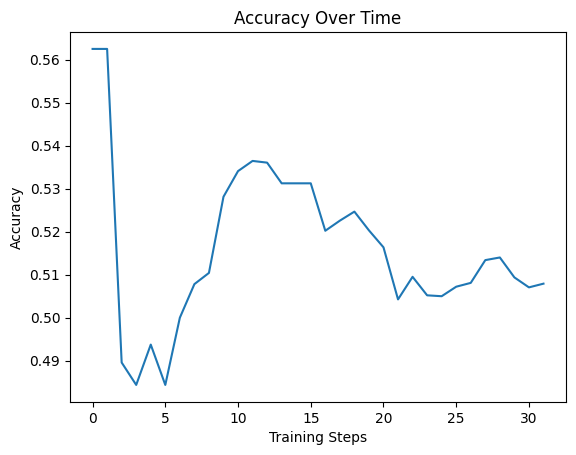

In [ ]:
# Calculate accuracy
accuracy_c = total_correct_predictions / total_predictions

# Calculate average reward per prediction
average_reward_per_prediction = total_reward / total_predictions

print("Accuracy:", accuracy_c)
print("Average Reward per Prediction:", average_reward_per_prediction)
print("Total Reward:", total_reward)

# Save the trained model
agent.model.save('dqn_agent_image_classification.h5')

# Plot accuracy over time
import matplotlib.pyplot as plt
plt.plot(accuracies)
plt.title('Accuracy Over Time')
plt.xlabel('Training Steps')
plt.ylabel('Accuracy')
plt.show()


In [ ]:
from tensorflow.keras.layers import LeakyReLU, ELU
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv2D, Dense, Flatten, BatchNormalization, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from collections import deque
import numpy as np
import random
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNet

class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=20000)  # Increased memory size
        self.batch_size = 32  # Increased batch size
        self.gamma = 0.95  # Increased discount rate
        self.epsilon = 1.0  # Initial exploration rate
        self.epsilon_min = 0.01  # Minimum exploration rate
        self.epsilon_decay = 0.995  # Decay rate for exploration
        self.learning_rate = 0.0001  # Learning rate
        self.model = self._build_model()

    def _build_model(self):
        base_model = MobileNet(weights='imagenet', include_top=False, input_shape=self.state_size)
        x = base_model.output
        x = GlobalAveragePooling2D()(x)
        predictions = Dense(self.action_size, activation='linear')(x)
        model = Model(inputs=base_model.input, outputs=predictions)
        model.compile(loss='mse', optimizer=Adam(lr=self.learning_rate))
        return model

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            q_values = self.model.predict(state)[0]
            logits = q_values / self.epsilon
            max_logit = np.max(logits)
            exp_logits = np.exp(logits - max_logit)
            probabilities = exp_logits / np.sum(exp_logits)
            action = np.random.choice(self.action_size, p=probabilities)
            return action
        else:
            act_values = self.model.predict(state)
            return np.argmax(act_values[0])

    def replay(self):
        if len(self.memory) < self.batch_size:
            return

        minibatch = random.sample(self.memory, self.batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                target = (reward + self.gamma * np.amax(self.model.predict(next_state)[0]))
            target_f = self.model.predict(state)
            target_f[0][action] = target
            self.model.fit(state, target_f, epochs=1, verbose=0)

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

# Initialize DQN Agent
state_size = (224, 224, 3)
num_classes = len(train_generator.class_indices)
action_size = num_classes
agent = DQNAgent(state_size, action_size)

# Add callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)
callbacks_list = [early_stopping, reduce_lr]

# Training loop
total_steps = len(train_generator)
total_correct_predictions = 0
total_predictions = 0
total_reward = 0
accuracies=[]

for step in range(total_steps):
    state_batch, label_batch = train_generator.next()
    batch_size = len(state_batch)
    for i in range(batch_size):
        state = np.reshape(state_batch[i], [1, *state_size])
        action = np.argmax(label_batch[i])  # Assuming one-hot encoding of labels

        reward = 3 if agent.act(state) == action else -1
        total_reward += reward

        total_predictions += 3
        if agent.act(state) == action:
            total_correct_predictions += 3

        next_state = state_batch[(i + 1) % batch_size]  # Assuming a sequential environment
        next_state = np.reshape(next_state, [1, *state_size])
        done = False  # You need to define when an episode is done

        agent.remember(state, action, reward, next_state, done)

    if step % 100 == 0:  # Only replay every 100 steps
        agent.replay()

    if agent.epsilon > agent.epsilon_min:
        agent.epsilon *= agent.epsilon_decay

    accuracy = total_correct_predictions / total_predictions
    accuracies.append(accuracy)

# print("Final Accuracy:", accuracies[-1])


1/1 [==============================] - 0s 98ms/step


Accuracy: 0.6198019801980198
Average Reward per Prediction: 0.504950495049505
Total Reward: 1530


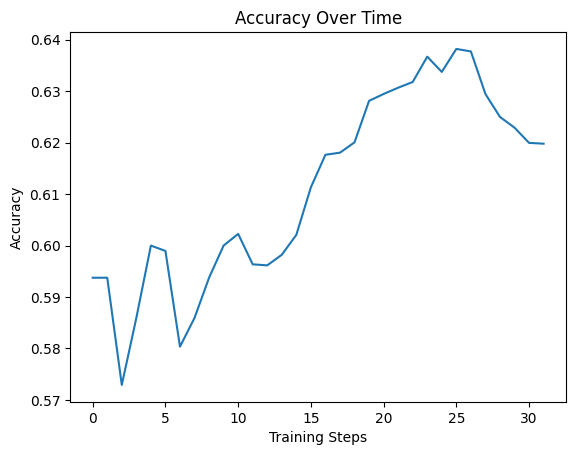

In [ ]:
# Calculate accuracy
accuracy_c = total_correct_predictions / total_predictions

# Calculate average reward per prediction
average_reward_per_prediction = total_reward / total_predictions

print("Accuracy:", accuracy_c)
print("Average Reward per Prediction:", average_reward_per_prediction)
print("Total Reward:", total_reward)

# Save the trained model
agent.model.save('dqn_agent_image_classification.h5')

# Plot accuracy over time
import matplotlib.pyplot as plt
plt.plot(accuracies)
plt.title('Accuracy Over Time')
plt.xlabel('Training Steps')
plt.ylabel('Accuracy')
plt.show()


In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np

# Load the trained DQN model
m5 = load_model('/content/dqn_agent_image_classification.h5')
def classify_image(image_path, model):
    # Load and preprocess the image
    img = image.load_img(image_path, target_size=(img_width, img_height))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.
    class_probabilities = model.predict(img_array)[0]
    predicted_class_index = np.argmax(class_probabilities)

    return predicted_class_index

class_names = {
    0: 'Cataract',
    1: 'Normal',
}

image_path ='/content/cataracts.jpg'
predicted_class_index = classify_image(image_path, m5)

predicted_class_name = class_names.get(predicted_class_index, 'Unknown')

# Print the predicted class name and class probabilities
print("Predicted Class Name:", predicted_class_name)


1/1 [==============================] - 1s 1s/step
Predicted Class Name: Cataract
